# 10.9.2 A Multilayer Network on the MNIST Digit Data

In [1]:
library(glmnet)
library(keras)

Loading required package: Matrix

Loaded glmnet 4.1-8



The `keras` package comes with a number of example datasets, including the `MNIST` digit data. Our first step is to load the `MNIST` data. The `dataset_mnist()` function is provided for this purpose.

In [2]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
g_train <- mnist$train$y
x_test <- mnist$test$x
g_test <- mnist$test$y
dim(x_train)
dim(x_test)

[1] 60000    28    28

[1] 10000    28    28

There are $60,000$ images in the training data and $10,000$ in the test data. The images are $28\times28$, and stored as a three-dimensional array, so we need to reshape them into a matrix. Also, we need to "one-hot" encode the class label. Luckily `keras` has a lot of built-in functions that do this for us.

In [3]:
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
y_train <- to_categorical(g_train, 10)
y_test <- to_categorical(g_test, 10)

Neural networks are somewhat sensitive to the scale of the inputs. For example, rige and lasso regularization are affected by scaling. Here the inputs are eight-bit grayscale values between $0$ and $255$, so we rescale to the unit interval.

In [4]:
x_train <- x_train / 255
y_test <- x_test / 255

Now we are ready to fit our neural network.

In [5]:
modelnn <- keras_model_sequential()
modelnn %>%
    layer_dense(units = 256, activation = "relu",
                input_shape = c(784)) %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 128, activation = "relu") %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 10, activation = "softmax")

The first layer goes from $28\times28 = 784$ input units to a hidden layer of $256$ units, which uses the ReLU activation function. This is specified by a call to `layer_dense()`, which takes as input a `modelnn` object, and returns a modified `modelnn` object. This is then piped through `layer_dropout()` to perform dropout regularization. The second hidden layer comes next, with $128$ hidden units, followed by a dropout layer. The final layer is the output layer, with activation `"softmax"` (10.13) for the $10$-class classification problem, which defines the map from the second hidden layer to class probabilities. FInally, we use `summary()` to summarize the model, and to make sure we got it all right.

In [6]:
summary(modelnn)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_2 (Dense)                    (None, 256)                     200960      
 dropout_1 (Dropout)                (None, 256)                     0           
 dense_1 (Dense)                    (None, 128)                     32896       
 dropout (Dropout)                  (None, 128)                     0           
 dense (Dense)                      (None, 10)                      1290        
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


The parameters for each layer include a bias term, which results in a parameter count of $235,146$. For example, the first hidden layer involves $(784 + 1) \times 256 = 200,960$ parameters.

Notice that the layer names such as `dropout_1` and `dense_2` have subscripts. These may appear somewhat random; in fact, if you fit the same model again, these will change. They are of no consequence: they vary because the model specification code is run in `python`, and these subscripts are incremented every time `keras_model_sequential()` is called.

Next, we add details to the model to specify the fitting algorithm. We fit the model by minimizing the cross-entropy function given by (10.14).

In [7]:
modelnn %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(), metrics = c("accuracy")
)

Now we are ready to go. The final step is to supply training data, and fit the model.

   user  system elapsed 
158.938  23.398  40.115 

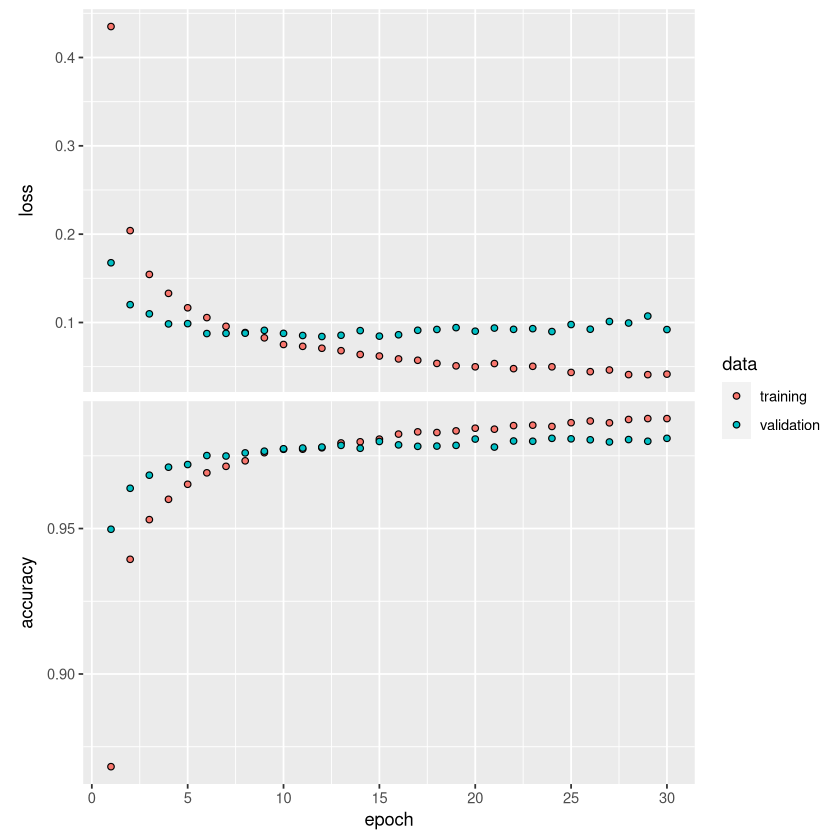

In [8]:
system.time(
    history <- modelnn %>%
        fit(x_train, y_train, epochs = 30, batch_size = 128, validation_split = 0.2))
plot(history, smooth = FALSE)

We suppressed the output here, which is a progress report on the fitting of the model, grouped by epoch. This is very useful, since on large datasets fitting can take time. Fitting this model took 144 seconds on a 2.9 GHz MacBook Pro with 4 cores and 32 GB of RAM. Here we specified a validation split of $20\%$, so the training is actually performed on $80\%$ of the $60,000$ observations in the training set. This is an alternative to actually supplying validation data, like we did in Section 10.9.1. See `?fit.keras.engine.training.Model` for all the optional fitting arguments. SGD uses batches of $128$ observations in computing the gradient, and doing the arithmetic, we see that an epoch corresponds to $375$ gradient steps. The last `plot()` command produces a figure similar to Figure 10.18.

To obtain the test error in Table 10.1, we first write a simple function `accuracy()` that compares predicted and true class labels, and then use it to evaluate our predictions.

In [9]:
accuracy <- function(pred, truth)
    mean(drop(pred) == drop(truth))
modelnn %>% predict_classes(x_test) %>% accuracy(g_test)

Warning message in predict_classes(., x_test):
“`predict_classes()` is deprecated and and was removed from tensorflow in version 2.6.
Please update your code:
  * If your model does multi-class classification:
    (e.g. if it uses a `softmax` last-layer activation).

      model %>% predict(x) %>% k_argmax()

  * if your model does binary classification
    (e.g. if it uses a `sigmoid` last-layer activation).

      model %>% predict(x) %>% `>`(0.5) %>% k_cast("int32")
”


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'mean': error in evaluating the argument 'x' in selecting a method for function 'drop': AttributeError: 'Sequential' object has no attribute 'predict_classes'
Run `reticulate::py_last_error()` for details.


The table also reports LDA (Chapter 4) and multiclass logistic regression. Although packages such as `glmnet` can handle multiclass logistic regression, they are quite slow on this large dataset. It is much faster and quite easy to fit such a model using the `keras` software. We just have an input layer and output layer, and omit the hidden layers!

In [10]:
modellr <- keras_model_sequential() %>% layer_dense(input_shape = 784, units = 10, activation = "softmax")
summary(modellr)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_3 (Dense)                    (None, 10)                      7850        
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


We fit the model just as before.

In [11]:
modellr %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_rmsprop(), metrics = c("accuracy"))
modellr %>% fit(x_train, y_train, epochs = 30, batch_size = 128, validation_split = 0.2)
modellr %>% predict_classes(x_test) %>% accuracy(g_test)

Warning message in predict_classes(., x_test):
“`predict_classes()` is deprecated and and was removed from tensorflow in version 2.6.
Please update your code:
  * If your model does multi-class classification:
    (e.g. if it uses a `softmax` last-layer activation).

      model %>% predict(x) %>% k_argmax()

  * if your model does binary classification
    (e.g. if it uses a `sigmoid` last-layer activation).

      model %>% predict(x) %>% `>`(0.5) %>% k_cast("int32")
”


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'mean': error in evaluating the argument 'x' in selecting a method for function 'drop': AttributeError: 'Sequential' object has no attribute 'predict_classes'
Run `reticulate::py_last_error()` for details.
